<h1 align="center">Real Estate Price Prediction</h1>

In this challenge we will predict the prices of apartments in Moscow. Real estate is a popular investment vehicle and can be pretty lucurative. Whether you're an individual looking for a place to call home or an investor looking for a profitable opportunity, being able to appraise assets accurately - or at least better than the next guy - can be of huge value.
    
We have been given a dataset consisting of information about over 33,000 apartments in Moscow. It contains around 30 variables that encode data such as location, facilities, and building information. We will do an analysis, feature engineering, and ultimately create models that can reliably predict the listed price of both low- and high-end apartments.



## 1. Loading Data

Loading external data

We use the same data folder provided on kaggle but with some csv files : It is additionnal data that help us to improve our score. This data is legit, It is for instance the distance to the nearest subway station. This folder is provided in our submission on BLACKBOARD and also in the following link : https://drive.google.com/drive/folders/1-4z5G7FYxyJrqBjG9cHiiBi5Z2ZjuNVV

Installing external Libraries :

In [68]:
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install

!pip install missingno
!pip install auto-sklearn
!pip install scipy
!pip install seaborn
!pip install geopy
!pip install haversine
!pip install lightgbm
!pip install xgboost
!pip install pipelineprofiler
!pip install optuna

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   249  100   249    0     0   1152      0 --:--:-- --:--:-- --:--:--  1152


**Storage** :
 ur data is on google drive into a folder called Data that contains the same data used in kaggle and also additionnal csv files to create new features such as the distance to nearest subway station

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [140]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno  # For missing data visualization
from google.colab import files
from geopy.distance import distance
from haversine import haversine, haversine_vector, Unit

# model stuff
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

import xgboost as xgb
import lightgbm as lgb

import sklearn.metrics as metrics
import autosklearn.metrics
import autosklearn.pipeline.components.regression
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.pipeline.components.base import AutoSklearnRegressionAlgorithm

import PipelineProfiler   # For auto-sklearn model interpretation  

np.random.seed(123)
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)


#FILE PATH TO THE DATA FOLDER
data_filepath = "./drive/MyDrive/data/"

pd.options.display.max_columns = None # Be careful using this with one-hot encoding



In [71]:
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc

### 1.1 Loading training set

We have training sets, a portion of a data set used to fit a model for prediction or classification of values that are known in the training set, but unknown in other future data. First of all we  load the data to study what are the different variables and take a first look to it. We run the two different: apartments and biuldings. 

### Apartments

In [72]:
apartments = pd.read_csv(data_filepath + 'apartments_train.csv')
print(f'Loaded {len(apartments)} apartments')
with open(data_filepath + 'apartments_meta.json') as f:
    apartments_meta = json.load(f)
describe_data(apartments, apartments_meta)

Loaded 23285 apartments


### Buildings

In [73]:
buildings = pd.read_csv(data_filepath + 'buildings_train.csv')
print(f'Loaded {len(buildings)} buildings')
with open(data_filepath + 'buildings_meta.json') as f:
    buildings_meta = json.load(f)
buildings.head()
describe_data(buildings, buildings_meta)

Loaded 6791 buildings


### 1.2 Combine apartment data with buildings

All apartments have an associated building, that is the reason why we merge both datasets to have the information in one and being able to work better.

In [74]:
print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
data.head()

All apartments have an associated building: True


id  seller       price  area_total  area_kitchen  area_living  floor  \
0   0     3.0   7139520.0        59.2          12.5         31.0    2.0   
1   1     NaN  10500000.0        88.0          14.2         48.0   18.0   
2   2     3.0   9019650.0        78.5          22.5         40.8   12.0   
3   3     NaN  10500000.0        88.0          14.0         48.0   18.0   
4   4     NaN  13900000.0        78.0          17.0         35.0    7.0   

   rooms  layout  ceiling  bathrooms_shared  bathrooms_private  windows_court  \
0    2.0     NaN     2.65               0.0                2.0            0.0   
1    3.0     1.0      NaN               2.0                0.0            1.0   
2    3.0     NaN     2.65               0.0                2.0            1.0   
3    3.0     NaN      NaN               0.0                2.0            1.0   
4    2.0     1.0     2.90               1.0                0.0            1.0   

   windows_street  balconies  loggias  condition  phones  building_id  new  \
0             1.0        NaN      NaN        NaN     1.0         4076  1.0   
1             1.0        1.0      0.0        3.0     1.0         1893  0.0   
2             1.0        NaN      NaN        NaN     1.0         5176  1.0   
3             1.0        0.0      1.0        2.0     1.0         1893  0.0   
4             1.0        0.0      1.0        3.0     1.0         6604  0.0   

    latitude  longitude  district             street address  constructed  \
0  55.544046  37.478055      11.0  Бунинские Луга ЖК  к2.5/2       2021.0   
1  55.861282  37.666647       2.0     улица Радужная    14к3       2010.0   
2  55.663299  37.515335       6.0  Саларьево Парк ЖК      38       2021.0   
3  55.861282  37.666647       2.0     улица Радужная    14к3       2010.0   
4  55.590785  37.451438      11.0   улица Сервантеса     1к3       2017.0   

   material  stories  elevator_without  elevator_passenger  elevator_service  \
0       3.0      9.0               0.0                 1.0               1.0   
1       3.0     25.0               0.0                 1.0               1.0   
2       3.0     15.0               0.0                 1.0               1.0   
3       3.0     25.0               0.0                 1.0               1.0   
4       2.0     15.0               0.0                 1.0               1.0   

   parking  garbage_chute  heating  
0      1.0            NaN      NaN  
1      1.0            NaN      0.0  
2      1.0            NaN      NaN  
3      1.0            NaN      0.0  
4      1.0            0.0      0.0

### 1.3 Loading test set

We also have a test dataset to check if our training is correct or need to improve.

In [75]:
apartments_test = pd.read_csv(data_filepath + 'apartments_test.csv')
buildings_test = pd.read_csv(data_filepath + 'buildings_test.csv')
print(f'All test apartments have an associated building: {apartments_test.building_id.isin(buildings_test.id).all()}')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
print(f'Number of train samples: {len(data)}')
print(f'Number of test samples:  {len(data_test)}')
data_test.head()

All test apartments have an associated building: True
Number of train samples: 23285
Number of test samples:  9937


id  seller  area_total  area_kitchen  area_living  floor  rooms  layout  \
0  23285     NaN        71.4           NaN          NaN    2.0    1.0     NaN   
1  23286     NaN        54.0           4.0         50.0    4.0    1.0     NaN   
2  23287     3.0        39.4          19.6         11.2   10.0    1.0     NaN   
3  23288     NaN        60.9           NaN          NaN    5.0    2.0     1.0   
4  23289     NaN        34.0           9.0         17.0   14.0    1.0     NaN   

   ceiling  bathrooms_shared  bathrooms_private  windows_court  \
0      NaN               NaN                NaN            1.0   
1     3.00               NaN                NaN            1.0   
2     2.65               1.0                0.0            1.0   
3      NaN               1.0                0.0            0.0   
4     2.75               1.0                0.0            1.0   

   windows_street  balconies  loggias  condition  phones  building_id  new  \
0             0.0        1.0      0.0        0.0     1.0         5148  0.0   
1             0.0        NaN      NaN        3.0     1.0         1290  0.0   
2             0.0        NaN      NaN        NaN     1.0          681  1.0   
3             1.0        NaN      NaN        0.0     1.0         4261  0.0   
4             0.0        0.0      1.0        1.0     1.0         7530  0.0   

    latitude  longitude  district                      street address  \
0  55.762247  37.549040       0.0     2-я Черногрязская улица     6к3   
1  55.591467  37.452651      11.0            улица Сервантеса     3к2   
2  55.617017  37.413718      11.0           Саларьево Парк ЖК      27   
3  55.569052  37.479510      11.0  улица Александры Монаховой      23   
4  55.518041  37.343829      11.0   улица 3-я Нововатутинская    13к1   

   constructed  material  stories  elevator_without  elevator_passenger  \
0       2017.0       2.0     20.0               1.0                 1.0   
1       2017.0       2.0     15.0               0.0                 1.0   
2       2021.0       3.0      9.0               0.0                 1.0   
3       2014.0       2.0     17.0               1.0                 1.0   
4       2016.0       2.0     17.0               0.0                 1.0   

   elevator_service  parking  garbage_chute  heating  
0               1.0      NaN            1.0      0.0  
1               1.0      0.0            0.0      0.0  
2               1.0      1.0            NaN      NaN  
3               0.0      NaN            1.0      3.0  
4               1.0      NaN            1.0      0.0

Both in the training set and the test set all apartments have an associated building.

**Thought** Maybe the test set on Kaggle contains apartments that are missing a corresponding building?

###1.4 Is the data intuitive ?

The data is not that intuitive, for instance some apartments have the floor higher than their storie value. This problem will be fixed in the data engineering part

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



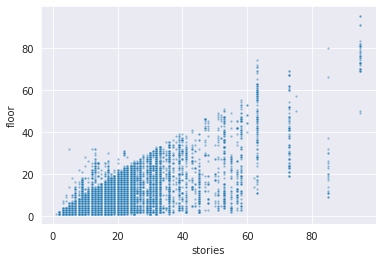

In [173]:
sns.scatterplot(data['stories'], all_data['floor'], s=5, alpha=0.5)

## 2.Exploratory Data Analysis

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.


### 2.1 Missing values
In statistics, missing data, or missing values, occur when no data value is stored for the variable in an observation. Missing data are a common occurrence and can have a significant effect on the conclusions that can be drawn from the data. That's why we are goint to analyse our data and clean it to achieve the best result possible

In [76]:
# fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
print(f'Number of missing price entries in train data: {data.price.isna().sum()}')
print(f'Training set features with any missing value: {data.isna().any().sum()}/{data.shape[1]}')
print(f'Testing set features with any missing value: {data_test.isna().any().sum()}/{data_test.shape[1]}')
# data.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
# data_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

Number of missing price entries in train data: 0
Training set features with any missing value: 23/34
Testing set features with any missing value: 25/33


In [77]:
# data is training apartments and buildings combined
data.isnull().sum().sum() # checking for total null values

130977

### 2.2 Price distribution

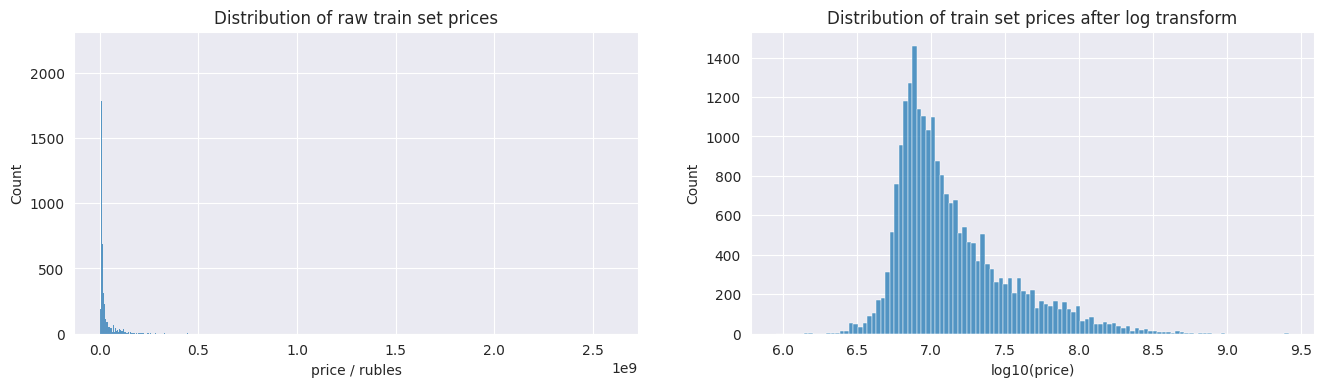

In [78]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
sns.histplot(data.price.rename('price / rubles'), ax=ax1)
ax1.set_title('Distribution of raw train set prices');
sns.histplot(np.log10(data.price).rename('log10(price)'), ax=ax2)
ax2.set_title('Distribution of train set prices after log transform');

We get a better distribution after log transforming our target. For this reason this transformation will be used later to make predictions (we also observed during many attempts that the scores were better with this type of transformation on the target)

### 2.3 Geographical data

(<matplotlib.axes._subplots.AxesSubplot at 0x7f50c259f0d0>,
 <matplotlib.colors.Normalize at 0x7f50b468c610>)

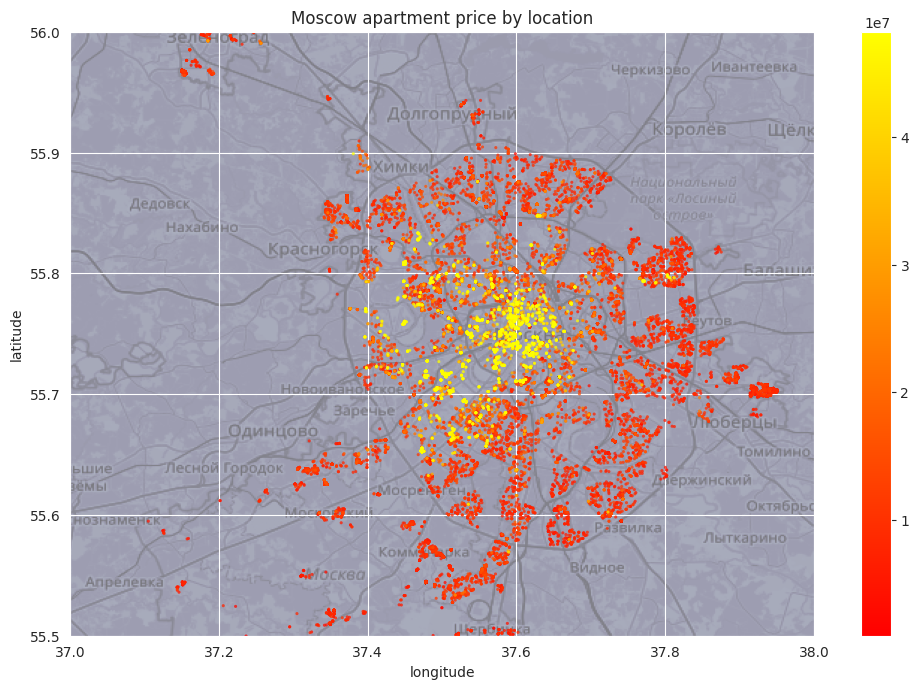

In [79]:
def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='price', title='Moscow apartment price by location'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread(data_filepath + 'moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

# Plotting price map
plot_map(data)


It seems that there is a correlation between price and nearness to the city centre.
Nonetheless, it seems that there is also a tendency for prices to be higher in the western part of Moscow.
Could this be related to the city district?

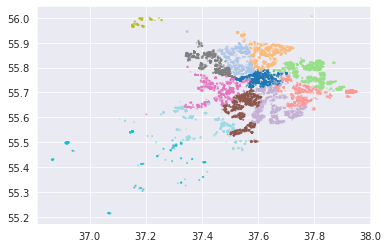

In [80]:
plt.scatter(data['longitude'], data['latitude'], alpha=0.3, s=1, c=data['district'], cmap='tab20')

Here we must keep in mind that since buildings have been
combined with apartments, the values of each building may be duplicated.


### 2.4 Visualizations for outliers and feature selection/importance

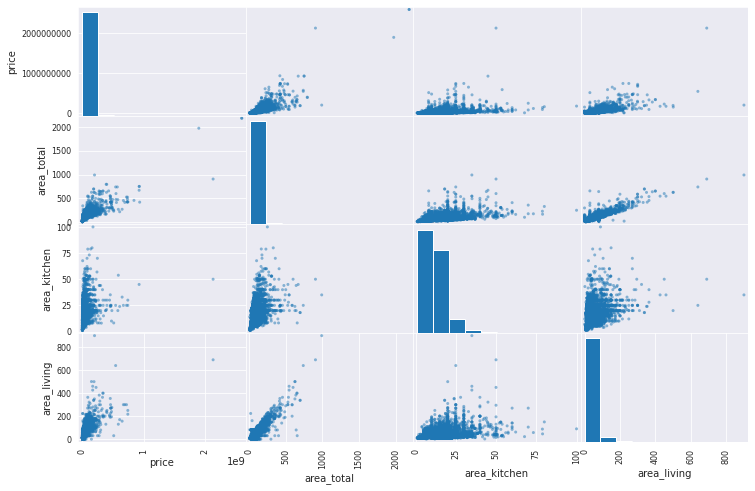

In [82]:
attributes = ["price", "area_total", "area_kitchen",
              "area_living"]
pd.plotting.scatter_matrix(data[attributes], figsize=(12, 8))
# plt.savefig(charts_filepath + "scatter_area_price")
plt.show()

There are many outliers, which can affect the performance of some models like linear regressions. During our various tests, we tried to use pre-processing pipelines that eliminate these outliers. However, this led us to worse results. This is due to the fact that we mainly used predictors based on decision trees (and gradient boosting) and these are not very sensitive to outliers.

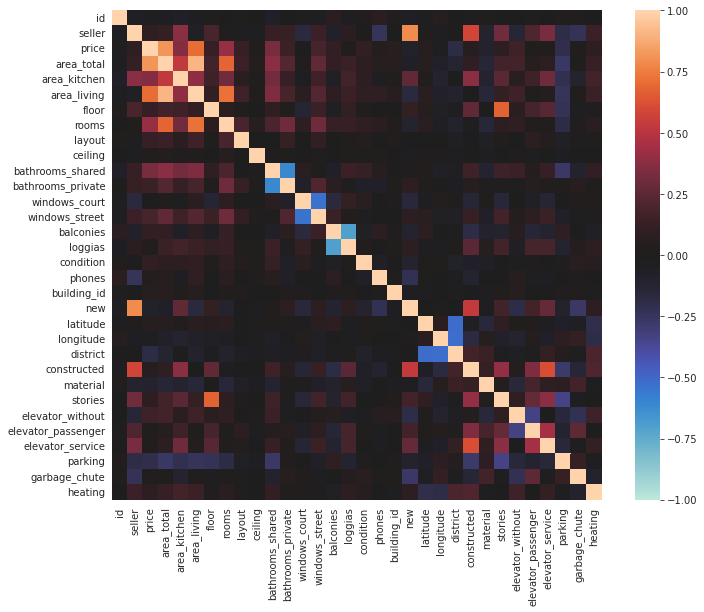

In [83]:
#correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True, vmin=-1, vmax=1, center=0);

This type of visualization allows first of all to better understand the features that are potentially important. These most relevant features can eventually be taken to train basic models like decision trees or randoms forest

##3. Data Cleaning 


Here we can see that some features are missing most of their data. We can then look at the importance of each feature:

In [84]:
data.corr()['price'].sort_values(ascending=False)

price                 1.000000
area_total            0.814829
area_living           0.707580
rooms                 0.411317
area_kitchen          0.364758
bathrooms_shared      0.332421
windows_street        0.180263
elevator_without      0.162024
bathrooms_private     0.133364
floor                 0.132206
layout                0.130822
condition             0.109338
balconies             0.102928
seller                0.101015
heating               0.087359
stories               0.086448
latitude              0.054341
building_id           0.052159
constructed           0.047633
phones                0.042738
ceiling               0.031640
garbage_chute         0.029171
loggias               0.024877
elevator_service      0.024681
elevator_passenger    0.021846
windows_court        -0.005345
id                   -0.027967
longitude            -0.034022
new                  -0.089292
material             -0.100614
district             -0.182404
parking              -0.199476
Name: pr

###3.1 Prepare the data 


We should keep in mind that each step of the pre-processing pipeline should be applied both to the train data and the test data used for the final predictions Kaggle. That's why we concatenate.

In [85]:
ap_train_id = apartments['id']
ap_test_id = apartments_test['id']
ap_bu_train_id = apartments['building_id']
ap_bu_test_id = apartments_test['building_id']
bu_train_id = buildings['id']
bu_test_id = buildings_test['id']

n_ap_train = apartments.shape[0]
n_ap_test = apartments_test.shape[0]
n_bu_train = buildings.shape[0]
n_bu_test = buildings_test.shape[0]

y_train = apartments.price.values

# apartments.drop('id', axis=1, inplace=True)
# apartments_test.drop('id', axis=1, inplace=True)
# buildings.drop('id', axis=1, inplace=True)
# buildings_test.drop('id', axis=1, inplace=True)

all_ap = pd.concat((apartments, apartments_test)).reset_index(drop=True)
all_bu = pd.concat((buildings, buildings_test)).reset_index(drop=True)

###3.2 Missing values : feature selection ?

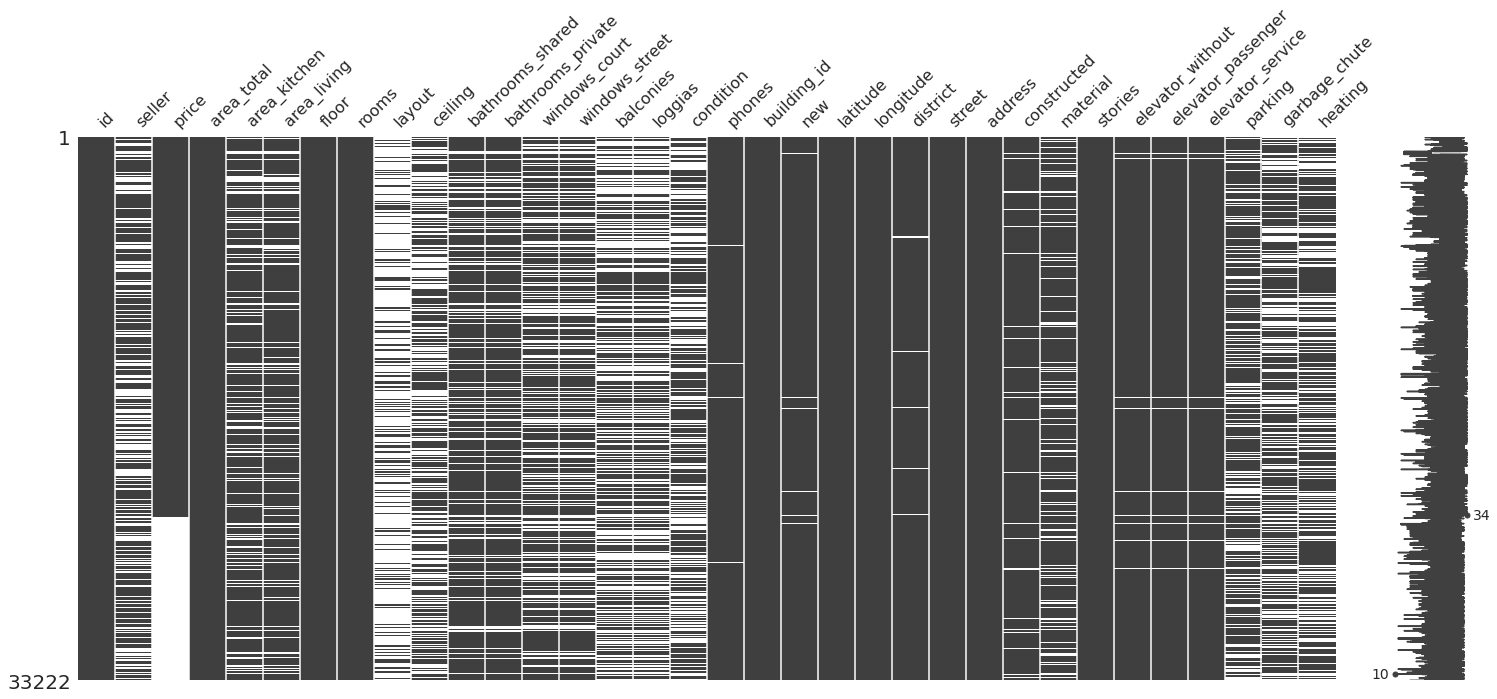

In [86]:
all_data = pd.merge(all_ap, all_bu.set_index('id'), how='left', left_on='building_id', right_index=True)
msno.matrix(all_data)

There are many missing values in the dataset. We use the Missingno librairy to better visualize them. This graph allows us to intuitively see which features are potentially to be discarded because of the missing proportion. For the models we used, we wanted to keep the features with a high rate because they proved to be useful to improve the predictions

###3.2 Missing values : filling the obvious ones

In [87]:
all_ap.drop(['price'], axis=1, inplace=True)

There is one building in the test set that doesn't have any location

In [88]:
all_bu.loc[pd.isnull(all_bu['longitude'])]

id  new  latitude  longitude  district           street  \
6798  3803  1.0       NaN        NaN       NaN  пос. Коммунарка   

             address  constructed  material  stories  elevator_without  \
6798  Москва А101 ЖК       2019.0       2.0     12.0               1.0   

      elevator_passenger  elevator_service  parking  garbage_chute  heating  
6798                 1.0               1.0      NaN            NaN      NaN

With its address we found the exact longitude and latitude on google maps for imputation :

In [89]:
all_bu['latitude'] = all_bu['latitude'].fillna(55.5675811)
all_bu['longitude'] = all_bu['longitude'].fillna(37.48152684)

We can see after that, that there is no building with any location remaining :

In [90]:
all_bu.loc[pd.isnull(all_bu['latitude'])]

Empty DataFrame
Columns: [id, new, latitude, longitude, district, street, address, constructed, material, stories, elevator_without, elevator_passenger, elevator_service, parking, garbage_chute, heating]
Index: []

In [91]:
all_bu.loc[pd.isnull(all_bu['longitude'])]

Empty DataFrame
Columns: [id, new, latitude, longitude, district, street, address, constructed, material, stories, elevator_without, elevator_passenger, elevator_service, parking, garbage_chute, heating]
Index: []

There is also some buildings with no district but we preferred to impute the missing values not by obvious guessing. In this long jupyter notebook we are using the same pre-processing pipeline for the 2 predictors used. The first one relies on automatic imputation done by the library Auto Scikit-Learn. The other relies on default imputation in the lightgbm library.

In [92]:
all_bu.loc[pd.isnull(all_bu['district'])]

id  new   latitude   longitude  district             street  \
5819  4162  1.0  55.595160   37.741109       NaN            23-й км   
6798  3803  1.0  55.567581   37.481527       NaN    пос. Коммунарка   
6805  1647  0.0  55.595160   37.741109       NaN            23-й км   
6973  5667  NaN  43.352968  132.759204       NaN  улица Центральная   
7016  6403  0.0  55.595160   37.741109       NaN            23-й км   
7159  7317  1.0  55.583551   37.711356       NaN            25-й км   
7187  2265  0.0  55.595160   37.741109       NaN            23-й км   
7352   926  0.0  55.921627   37.781578       NaN              В мкр   
7899  4412  1.0  17.141734  -61.790500       NaN  Бунинские Луга ЖК   
8316  6879  0.0  55.932127   37.793705       NaN              В мкр   
9061  4202  NaN  42.914700   74.517184       NaN    улица 1-я Линия   
9179   183  0.0  55.595160   37.741109       NaN            23-й км   
9512  8811  0.0  43.353545  132.768097       NaN  улица Центральная   
9629  4636  1.0  17.141734  -61.790500       NaN  Бунинские Луга ЖК   

             address  constructed  material  stories  elevator_without  \
5819             5к1       2021.0       3.0      9.0               0.0   
6798  Москва А101 ЖК       2019.0       2.0     12.0               1.0   
6805             7к1       2018.0       NaN     25.0               1.0   
6973              48          NaN       NaN      2.0               NaN   
7016            11к1       2019.0       NaN     16.0               0.0   
7159           вл1с1          NaN       NaN     13.0               NaN   
7187            13к2       2018.0       NaN     25.0               0.0   
7352              37       1989.0       2.0     16.0               0.0   
7899          к2/2/2       2021.0       NaN      9.0               0.0   
8316              30       1975.0       2.0      9.0               0.0   
9061              57       2016.0       NaN      3.0               NaN   
9179            11к2       2019.0       NaN     25.0               0.0   
9512              75       2007.0       NaN      5.0               0.0   
9629          к2/2/1       2021.0       3.0     17.0               1.0   

      elevator_passenger  elevator_service  parking  garbage_chute  heating  
5819                 1.0               1.0      1.0            NaN      1.0  
6798                 1.0               1.0      NaN            NaN      NaN  
6805                 1.0               1.0      2.0            0.0      NaN  
6973                 NaN               NaN      NaN            NaN      NaN  
7016                 1.0               1.0      0.0            1.0      NaN  
7159                 NaN               NaN      NaN            NaN      NaN  
7187                 1.0               1.0      2.0            NaN      NaN  
7352                 1.0               1.0      NaN            1.0      0.0  
7899                 1.0               1.0      NaN            NaN      NaN  
8316                 1.0               0.0      1.0            1.0      0.0  
9061                 NaN               NaN      NaN            NaN      NaN  
9179                 1.0               1.0      1.0            1.0      NaN  
9512                 1.0               1.0      1.0            1.0      NaN  
9629                 0.0               0.0      NaN            0.0      NaN

### 3.3 Missing values : cleaning apartments and building data

The code is commented with ##
This is just basic imputation for missing values that we tried for the first models of our project.

In [93]:
# Introducing new category for unknown seller
##aall_ap['seller'] = all_ap['seller'].fillna(4)

# Should use more sophisticated method involving other areas
##aall_ap['area_kitchen'] = all_ap['area_kitchen'].replace(np.NaN, all_ap['area_kitchen'].mean())
##aall_ap['area_living'] = all_ap['area_living'].replace(np.NaN, all_ap['area_living'].mean())

# Introducing new category for unknown layout
##aall_ap['layout'] = all_ap['layout'].fillna(4)
##aall_ap['ceiling'] = all_ap['ceiling'].replace(np.NaN, all_ap['ceiling'].mean())

# Should use more sophisticated method involving other counterpart
##aall_ap['bathrooms_shared'] = all_ap['bathrooms_shared'].replace(np.NaN, all_ap['bathrooms_shared'].median())
##aall_ap['bathrooms_private'] = all_ap['bathrooms_private'].replace(np.NaN, all_ap['bathrooms_private'].median())

# Should maybe use more sophisticated method involving other counterpart
##aall_ap['windows_court'] = all_ap['windows_court'].replace(np.NaN, all_ap['windows_court'].median())
##aall_ap['windows_street'] = all_ap['windows_street'].replace(np.NaN, all_ap['windows_street'].median()) # This can maybe be inferred from street?

##aall_ap['balconies'] = all_ap['balconies'].replace(np.NaN, all_ap['balconies'].median())
##aall_ap['loggias'] = all_ap['loggias'].replace(np.NaN, all_ap['loggias'].median())

# NaN most likely means undecorated
##aall_ap['condition'] = all_ap['condition'].fillna(3)

##aall_ap['phones'] = all_ap['phones'].replace(np.NaN, 0)

In [94]:
##all_bu['new'] = all_bu['new'].replace(np.NaN, all_bu['new'].median()) # New can be inferred from constructed

##all_bu['district'] = all_bu['district'].fillna(13) # District can be inferred from location
                                                   # District can be used to infer other missing values

##all_bu['latitude'] = all_bu.groupby(['street'])['latitude'].transform(lambda x: x.fillna(x.median()))
##all_bu['longitude'] = all_bu.groupby(['street'])['longitude'].transform(lambda x: x.fillna(x.median()))

# all_bu['longitude'] = all_bu.groupby(['district'])['longitude'].transform()

##all_bu['constructed'] = all_bu['constructed'].replace(np.NaN, all_bu['constructed'].mean()) # Constructed and new are related, can be used to infer
##all_bu['material'] = all_bu['material'].replace(np.NaN, all_bu['material'].median()) # Could maybe be inferred from district

# Could maybe be inferred from stories and eachother
##all_bu['elevator_without'] = all_bu['elevator_without'].replace(np.NaN, all_bu['elevator_without'].median())
##all_bu['elevator_passenger'] = all_bu['elevator_passenger'].replace(np.NaN, all_bu['elevator_passenger'].median())
##all_bu['elevator_service'] = all_bu['elevator_service'].replace(np.NaN, all_bu['elevator_service'].median())

# Introducing new category for unknown parking, could maybe be inferred from other features
##all_bu['parking'] = all_bu['parking'].fillna(3)

# Could maybe be inferred from stories/district/built
##all_bu['garbage_chute'] = all_bu['garbage_chute'].replace(np.NaN, all_bu['garbage_chute'].median())

# Introducing new category for unknown heating
##all_bu['heating'] = all_bu['heating'].fillna(3)

We must impute the missing values for elevator_without since this feature is used after for feature generation

In [95]:
all_bu['elevator_without'] = all_bu['elevator_without'].replace(np.NaN, all_bu['elevator_without'].median()) 

Our data is now "cleaned" and ready to be used for feature engineering. We drop the id features since there are not relevant :

In [96]:
all_data = pd.merge(all_ap, all_bu.set_index('id'), how='left', left_on='building_id', right_index=True)

all_data.drop('id', axis=1, inplace=True)
all_data.drop('building_id', axis=1, inplace=True)

The missing values with be handled during the training of our model (automl with scikit-learn find the best imputation to maximize our metric) :

In [97]:
all_data.isnull().sum().sum()

187341

### 3.4 The case of the location tuple (longitude,latitude)

#### 3.4.1 Explore these features (explore pairs of features)

As we can see on the following plots there is some buildings far outside the city : this is just an error during the gathering of the dataset

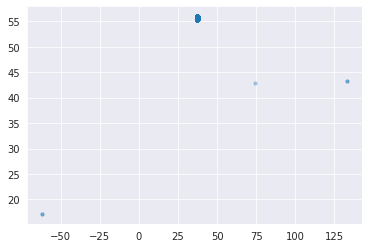

In [98]:
plt.scatter(all_bu['longitude'], all_bu['latitude'], alpha=0.3, s=10)

These buildings with false location have a latitude inferior to 50 :

In [99]:
all_bu.loc[all_bu['latitude'] < 50]

id  new   latitude   longitude  district             street address  \
6973  5667  NaN  43.352968  132.759204       NaN  улица Центральная      48   
7899  4412  1.0  17.141734  -61.790500       NaN  Бунинские Луга ЖК  к2/2/2   
9061  4202  NaN  42.914700   74.517184       NaN    улица 1-я Линия      57   
9512  8811  0.0  43.353545  132.768097       NaN  улица Центральная      75   
9629  4636  1.0  17.141734  -61.790500       NaN  Бунинские Луга ЖК  к2/2/1   

      constructed  material  stories  elevator_without  elevator_passenger  \
6973          NaN       NaN      2.0               0.0                 NaN   
7899       2021.0       NaN      9.0               0.0                 1.0   
9061       2016.0       NaN      3.0               0.0                 NaN   
9512       2007.0       NaN      5.0               0.0                 1.0   
9629       2021.0       3.0     17.0               1.0                 0.0   

      elevator_service  parking  garbage_chute  heating  
6973               NaN      NaN            NaN      NaN  
7899               1.0      NaN            NaN      NaN  
9061               NaN      NaN            NaN      NaN  
9512               1.0      1.0            1.0      NaN  
9629               0.0      NaN            0.0      NaN

#### 3.4.2 Clean up these features

We can fix these errors by finding the exact location on google maps thanks to the address :

In [100]:
all_bu.at[6973, 'latitude'] = 55.63384636810666
all_bu.at[6973, 'longitude'] = 37.41986901627135

all_bu.at[7899, 'latitude'] = 55.54371958666631
all_bu.at[7899, 'longitude'] = 37.48233889847151

all_bu.at[9061, 'latitude'] = 55.62773817227544
all_bu.at[9061, 'longitude'] = 37.46499797519564

all_bu.at[9512, 'latitude'] = 55.80920516603121
all_bu.at[9512, 'longitude'] = 37.34990449848708

all_bu.at[9629, 'latitude'] = 55.54371958666631
all_bu.at[9629, 'longitude'] = 37.48233889847151

Then we can check that the is no errors remaining :

In [101]:
all_bu.loc[all_bu['latitude'] < 50]

Empty DataFrame
Columns: [id, new, latitude, longitude, district, street, address, constructed, material, stories, elevator_without, elevator_passenger, elevator_service, parking, garbage_chute, heating]
Index: []

In [102]:
all_bu.loc[all_bu['longitude'] > 50]

Empty DataFrame
Columns: [id, new, latitude, longitude, district, street, address, constructed, material, stories, elevator_without, elevator_passenger, elevator_service, parking, garbage_chute, heating]
Index: []

In [103]:
all_bu.loc[all_bu['longitude'] < 0]

Empty DataFrame
Columns: [id, new, latitude, longitude, district, street, address, constructed, material, stories, elevator_without, elevator_passenger, elevator_service, parking, garbage_chute, heating]
Index: []

## 4. Feature Engineering

### 4.1 Encoding the address feature

In [104]:
# Convert street string to int, similar to district:
street_dict = {}
def convert_to_int(street):
    if street in street_dict: return street_dict[street]
    integer = len(street_dict.keys())
    street_dict[street] = integer
    return integer

In [105]:
all_bu['ordinal_street'] = np.array([convert_to_int(word) for word in all_bu['street']])  # Useful for feature engineering, i.e. groupby()

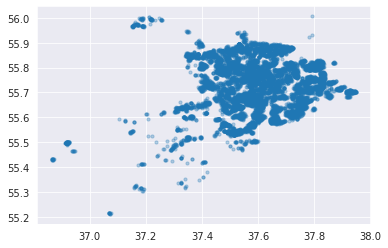

In [106]:
plt.scatter(all_bu['longitude'], all_bu['latitude'], alpha=0.3, s=10)

### 4.2 Feature generation by adding external new data

We used some external data in order to improve the performance of our models. To do this we used data that is interesting at first glance: whether the apartment is close to a transport infrastructure or a park. Our pipeline is using basic feature generation while the other (at the end/second part of the notebook) uses more advance stuff the sources for the external data are listed. The more advanced stuff

In [107]:
from haversine import haversine, haversine_vector, Unit

all_bu['coordinates'] = list(zip(all_bu['latitude'], all_bu['longitude'])) #New feature created from the existing ones : It allows use to compute a distance to the nearest facility

def get_min_distance(feature_name):
  feature = pd.read_csv(f'{data_filepath}{feature_name}.csv', dtype='float64')
  feature['coordinates'] = list(zip(feature['latitude'], feature['longitude']))

  bu_coord = all_bu['coordinates'].to_numpy(copy=True).tolist()
  feature_coord = feature['coordinates'].to_numpy(copy=True).tolist()

  distances = haversine_vector(bu_coord, feature_coord, unit=Unit.KILOMETERS, comb=True)

  distances_frame = pd.DataFrame(data=distances)
  feature_min = pd.DataFrame({f'{feature_name}_min': distances_frame.min(axis=0)})
  feature_min.to_csv(f'{data_filepath}{feature_name}_min.csv', index=False)
  all_bu[f'{feature_name}_min'] = feature_min

#The we just compute the distance for each apartments with the nearest facility :
get_min_distance('subway') #subway station
get_min_distance('train') #train station
get_min_distance('tram') #tram station
get_min_distance('park') #garden park


Then we create a new feature that combines the 3 previous features. This feature shows the minimum distance from the apartments to a facilitie (the intuitive reason behind the choice of this feature is that facilities for the daily life have an impact on the price of the apartment)

In [108]:
all_bu['transit_min'] = all_bu[['subway_min', 'train_min', 'tram_min']].min(axis=1)

### 4.3 Feature generation from the data provided in Kaggle

#### 4.3.1 Radius

We created a feature to compute the distance from the apartment to the center of the city

In [109]:
latitude_mean = all_bu['latitude'].mean(axis=0, skipna=True)
longitude_mean = all_bu['longitude'].mean(axis=0, skipna=True)
latitude_kremlin = 55.75202223    # Dist, to kremlin yields lower correlation than mean
longitude_kremlin = 37.61749837

difference_latitude = all_bu['latitude'] - latitude_mean
difference_longitude = all_bu['longitude'] - longitude_mean
radius = pd.DataFrame({"radius":np.sqrt(np.square(difference_latitude) + np.square(difference_longitude))})

middle = (latitude_mean, longitude_mean)

In [110]:
radius = all_bu['coordinates'].apply(lambda x: distance(x, middle))
print(radius)

0       27.718813798996212 km
1       17.894455187718517 km
2       13.804772136667419 km
3       10.564208917128559 km
4       11.682989908097436 km
                ...          
9717     18.41996342156538 km
9718     20.70334511559352 km
9719    15.903638442296476 km
9720    15.722486268652734 km
9721     18.66303580013286 km
Name: coordinates, Length: 9722, dtype: object


Convert to int to be consistent with the data types used in the dataset :

In [111]:
radius = radius.astype(str).str[:-3].astype(float)

In [112]:
print(radius)

0       27.718814
1       17.894455
2       13.804772
3       10.564209
4       11.682990
          ...    
9717    18.419963
9718    20.703345
9719    15.903638
9720    15.722486
9721    18.663036
Name: coordinates, Length: 9722, dtype: float64


In [113]:
middle

(55.72763494568813, 37.59281507438056)

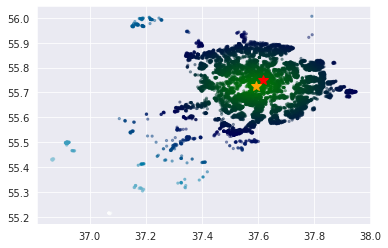

In [114]:
all_bu['radius'] = pd.DataFrame({"radius":radius})
all_bu['closeness'] = 1 / np.sqrt(radius)

# Making sure that result looks sensible
plt.scatter(all_bu['longitude'], all_bu['latitude'], alpha=0.4, s=5, c=all_bu['radius'], cmap='ocean')
plt.plot(longitude_kremlin, latitude_kremlin, marker='*', markersize=10, color="red", label='kremlin')
plt.plot(longitude_mean, latitude_mean, marker='*', markersize=10, color="orange", label='city centre')

In [115]:
all_bu['radius'].max()

66.26513516044717

#### 4.3.2 Living area per room

This feature was not used, It was not relevant even for the basic models :

In [116]:
# all_ap['living_area_per_room'] = all_ap['area_living'] / (all_ap['rooms'] + 1)  # +1 to avoid divide by zero

#### 4.3.3 Combining and partitioning cleaned data

In [117]:
# Getting new test and train sets:

apartments = all_ap[:n_ap_train]
apartments['price'] = y_train         # train set
# apartments.drop(index=2804, inplace=True)
# apartments.drop(index=15840, inplace=True)
# apartments.drop(index=21414, inplace=True)
apartments_test = all_ap[n_ap_train:] # number in train

buildings = all_bu[:n_bu_train]
buildings_test = all_bu[n_bu_train:]

data = pd.merge(apartments, buildings.set_index('id'), how='inner', left_on='building_id', right_index=True)
data_y = data['price']
data_x = data.drop(['price'], axis=1)

data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='inner', left_on='building_id', right_index=True)

n_train = data.shape[0]
all_data = pd.concat((data, data_test)).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### 4.3.4 Stairs to walk and kegness

(Exploring a pair of features + cleaning )

Some values are inconsistent and need to be cleaned up before creating our new feature.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


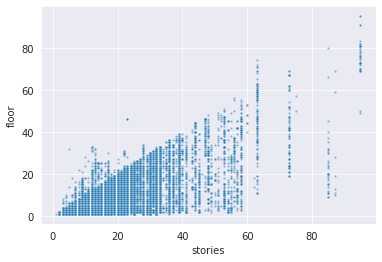

In [118]:
sns.scatterplot(all_data['stories'], all_data['floor'], s=5, alpha=0.5)

In [119]:
compressed_floor = all_data.groupby(['building_id'])['floor'].transform(lambda x: x - x.min())
compressed_stories = all_data.groupby(['building_id'])['floor'].transform(lambda x: x.max())

In [120]:
all_data['stairs_to_walk'] = pd.DataFrame({"stairs_to_walk": 1 / ((1 - all_data['elevator_without'])* (compressed_stories - compressed_floor) + 1)})

In [121]:
all_data['kegness'] = all_data['area_total'] / all_data['radius']

#### 4.4 Definining datatypes

In [122]:
all_data['seller'] = all_data['seller'].astype('category')
all_data['layout'] = all_data['layout'].astype('category')
all_data['condition'] = all_data['condition'].astype('category')
all_data['district'] = all_data['district'].astype('category')
all_data['street'] = all_data['street'].astype('category')
all_data['address'] = all_data['address'].astype('category')
all_data['material'] = all_data['material'].astype('category')
all_data['parking'] = all_data['parking'].astype('category')
all_data['heating'] = all_data['heating'].astype('category')

In [123]:
data = all_data[:n_train]
data_test = all_data[n_train:]

Our dataset is ready, we can see the features with the highest positive of negative correlation maybe for feature selection :

In [124]:
corrmat = data.corr()
corrmat['price'].sort_values(ascending=False)

price                 1.000000
area_total            0.814829
kegness               0.748992
area_living           0.707580
closeness             0.417542
rooms                 0.411317
area_kitchen          0.364758
bathrooms_shared      0.332421
windows_street        0.180263
elevator_without      0.162832
stairs_to_walk        0.161499
bathrooms_private     0.133364
floor                 0.132206
balconies             0.102928
stories               0.086448
park_min              0.065691
latitude              0.054341
building_id           0.052159
constructed           0.047633
phones                0.042738
ceiling               0.031640
garbage_chute         0.029171
loggias               0.024877
elevator_service      0.024681
elevator_passenger    0.021846
ordinal_street        0.020298
windows_court        -0.005345
id                   -0.027967
longitude            -0.034022
subway_min           -0.087259
new                  -0.089292
transit_min          -0.093826
train_mi

#### 4.5 Recreate train/test split and FEATURE SELECTION


1.   We drop the id features
2.   We drop the coordinates feature which is no longer useful and the 3 intermediate features.
3.   We use One-Hot encoding to improve the performance of our boosting tree models. That's why we have to drop the street (and ordinal_street) and adress because there is too many different categories.




In [125]:
final_train = data.drop(['id', 'building_id', 'street', 'ordinal_street', 'address', 'coordinates', 'tram_min', 'train_min', 'subway_min'], axis=1) # 'windows_court', 'phones', 'new'
final_test = data_test.drop(['id', 'building_id', 'street', 'ordinal_street', 'address', 'coordinates', 'tram_min', 'train_min', 'subway_min'], axis=1) # 'windows_court', 'phones', 'new'

#### 4.6 OneHot Encoding

In [126]:
one_hot_encoded_training_predictors = pd.get_dummies(final_train)
one_hot_encoded_test_predictors = pd.get_dummies(final_test)

final_train, final_test = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors,
                                                                    join='inner', 
                                                                    axis=1)
final_test.drop(['price'], axis=1, inplace=True)

OneHot encoding is just increasing the number of null values

In [127]:
final_train.isnull().sum().sum()

75287

In [128]:
final_test.isnull().sum().sum()

33659

#### 4.7 Log transform target

In [129]:
final_train['price'] = np.log(final_train['price'])
data_y = np.log(data_y)

In [130]:
final_train.head()

area_total  area_kitchen  area_living  floor  rooms  ceiling  \
0        59.2          12.5         31.0    2.0    2.0     2.65   
1        19.8           5.2          9.6   17.0    1.0     2.65   
2        79.7          17.0         41.5    9.0    3.0     2.65   
3        23.4           6.1         11.3    9.0    1.0     2.65   
4        23.8           6.1         11.3    9.0    1.0     2.65   

   bathrooms_shared  bathrooms_private  windows_court  windows_street  \
0               0.0                2.0            0.0             1.0   
1               1.0                0.0            1.0             0.0   
2               0.0                2.0            1.0             1.0   
3               1.0                0.0            1.0             0.0   
4               1.0                0.0            1.0             0.0   

   balconies  loggias  phones      price  new   latitude  longitude  \
0        NaN      NaN     1.0  15.781156  1.0  55.544046  37.478055   
1        NaN      NaN     1.0  15.213027  1.0  55.544046  37.478055   
2        NaN      NaN     1.0  16.066828  1.0  55.544046  37.478055   
3        NaN      NaN     1.0  15.280306  1.0  55.544046  37.478055   
4        NaN      NaN     1.0  15.281997  1.0  55.544046  37.478055   

   constructed  stories  elevator_without  elevator_passenger  \
0       2021.0      9.0               0.0                 1.0   
1       2021.0      9.0               0.0                 1.0   
2       2021.0      9.0               0.0                 1.0   
3       2021.0      9.0               0.0                 1.0   
4       2021.0      9.0               0.0                 1.0   

   elevator_service  garbage_chute     park_min  transit_min     radius  \
0               1.0            NaN  2414.244804     1.940709  21.680051   
1               1.0            NaN  2414.244804     1.940709  21.680051   
2               1.0            NaN  2414.244804     1.940709  21.680051   
3               1.0            NaN  2414.244804     1.940709  21.680051   
4               1.0            NaN  2414.244804     1.940709  21.680051   

   closeness  stairs_to_walk   kegness  seller_0.0  seller_1.0  seller_2.0  \
0   0.214768        0.058824  2.730621           0           0           0   
1   0.214768        0.500000  0.913282           0           0           0   
2   0.214768        0.100000  3.676191           0           0           0   
3   0.214768        0.100000  1.079333           0           0           0   
4   0.214768        0.100000  1.097783           0           0           0   

   seller_3.0  layout_0.0  layout_1.0  layout_2.0  condition_0.0  \
0           1           0           0           0              0   
1           1           0           0           0              0   
2           1           0           0           0              0   
3           1           0           0           0              0   
4           1           0           0           0              0   

   condition_1.0  condition_2.0  condition_3.0  district_0.0  district_1.0  \
0              0              0              0             0             0   
1              0              0              0             0             0   
2              0              0              0             0             0   
3              0              0              0             0             0   
4              0              0              0             0             0   

   district_2.0  district_3.0  district_4.0  district_5.0  district_6.0  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   district_7.0  district_8.0  district_9.0  district_10.0  district_11.0  \
0             0  

We drop the price since it's our target :

In [131]:
final_train.drop(['price'], axis=1, inplace=True)

## 5. First predictor : Automl with Auto Sklearn

Auto-Sklearn is a library for performing AutoML in Python.  AutoML, or Automated Machine Learning, refers to a technology that automatically discovers good models for predictive modeling tasks without user involvement.
The Auto-Sklearn architecture consists of 3 phases: meta-learning, Bayesian optimization and set selection. 
The key idea of the meta-learning phase is to reduce the search space by learning from models that performed well on similar datasets. Immediately afterwards, the Bayesian optimization phase takes the space search created in the meta-learning step and creates Bayesian models to find the optimal pipeline configuration. Finally, a set selection model is created by reusing the most accurate models found in the Bayesian optimization step. 

In [133]:
training_time = 60 * 60 * 2 

We are using cross-validation instead of using a train/sub-test split to improve the performance of the model. The fold is set 

In [134]:
auto_regr = AutoSklearnRegressor(time_left_for_this_task= training_time, 
                                 per_run_time_limit=45,
                                 metric=autosklearn.metrics.root_mean_squared_error, # since the target is log transformed we don't use RMSLE
                                 resampling_strategy='cv',
                                 resampling_strategy_arguments={'folds':5}, 
                                 seed=41)

In [135]:
auto_regr.fit(final_train, data_y, dataset_name='Moscow Housing Kaggle')

AutoSklearnRegressor(metric=root_mean_squared_error, per_run_time_limit=45,
                     resampling_strategy='cv',
                     resampling_strategy_arguments={'folds': 5}, seed=41,
                     time_left_for_this_task=300)

In [136]:
auto_regr_predictions = auto_regr.predict(final_test)
auto_regr_predictions = np.exp(auto_regr_predictions)

In [137]:
prediction_frame = pd.DataFrame(columns={'id': data_test['id'], 'price_prediction': auto_regr_predictions})
prediction_frame['id'] = data_test['id']
prediction_frame['price_prediction'] = auto_regr_predictions
prediction_frame.to_csv(f'{data_filepath}prediction/auto_regr_automl_{training_time / 60}_mins.csv', index=False)

### 5.3 Model interpretation

#### 5.3.1 Feature importance

Unfortunately, Auto-sklearn can not give any general feature importance information.

#### 5.3.2 Pipeline Profiler

Here we can see the final ensemble of models and their corresponding RMSE score, as well as their preprocessing pipelines. 
The pipelines consist of a combination of feature preprocessing done automatically by auto sklearn and  egression models. 
We can see that the best scoring models are all gradient boosting. 
The preprocessing that works best with gradient boosting is in our case feature_agglomeration.
Other good scoring models are adaboost, extra trees, mlp, linear svr and ard regression.

In [177]:
profiler = PipelineProfiler.import_autosklearn(auto_regr)
PipelineProfiler.plot_pipeline_matrix(profiler)

#### 5.3.3 Model performance

In [178]:
print(auto_regr.leaderboard())

          rank  ensemble_weight               type      cost  duration
model_id                                                              
7            1              1.0  gradient_boosting  0.200708  11.39299


This model was just runned during 5 minutes but the one we use in the short jupyter notebook is runned for 2hours and has also gradient_boosting as the best performing model

In [179]:
print(auto_regr.sprint_statistics())

auto-sklearn results:
  Dataset name: Moscow Housing Kaggle
  Metric: root_mean_squared_error
  Best validation score: 0.200708
  Number of target algorithm runs: 11
  Number of successful target algorithm runs: 1
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 6
  Number of target algorithms that exceeded the memory limit: 4



This plot is useful to see that using an ensemble from the auto sklearn regressor is better than a model alone

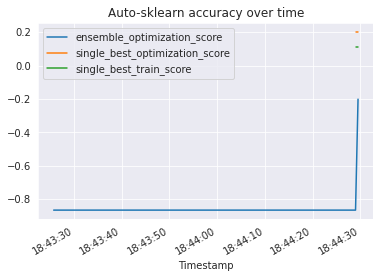

In [180]:
poT = auto_regr.performance_over_time_
poT.plot(
   x='Timestamp',
   kind='line',
   legend=True,
   title='Auto-sklearn accuracy over time',
   grid=True,
)
plt.show()

## 6. Second predictor : Lightgbm library with Optuna library for tuning hyperparameters

**Why did we used LighGBM as a predictor ?**

We used LightGBM due to its popularity across the machine learning community (It could be considered as a state-of-the-art model) and also because of its speed : the iteration during hyperparameter tuning is very fast which allows us to try several configurations.

**Missing values**

The same there, LightGBM library doesn't need imputation : missing values are handled with a split-direction at each split.

**Hyperparameter optimization**

The hyperparameters of our LightGBM model are tuned using the library Optuna which is really useful. The library implement a hyperparameter optimization by tuning the following parameters (in order) :



1.   feature_fraction
2.   num_leaves
3.   bagging parameters (e.g bagging_fraction, bagging_freq)
4.   feature_fraction (second time)
5.   regularization parameters (the lambdas)
6.   min_chil_samples



This is really useful since theses hyperparameters are often sensible to overfitting (and sometimes underfitting)

### 6.1 Optuna library for fine-tuning 

**Tuning**

We while train the LightGBM several times and for each training, the hyperparameters that we get as the output optimize our metric of interest which is the RMSE (not RMSLE since the target has been log trasnformed)

A objective fucntion (LightGBM documentation) is used to tune the parameters during each training.

We use a basic train/test split for the validation with a ratio of 80/20

Finnaly, optuna select the best parameters with the optimize study parameters.

In [147]:
import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

import optuna

num_trials = 100


def my_eval_metric(valid_y, pred_labels):# custom metric
     

  return autosklearn.metrics.root_mean_squared_error(valid_y, pred_labels)

def objective(trial):
     
     train_x, valid_x, train_y, valid_y = train_test_split(final_train, data_y, test_size=0.2)
     dtrain = lgb.Dataset(train_x, label=train_y)
     

     #For each hyperparameters we can set a specific range of values to test
     #For instance, the values below can be tuned/tweak with a hyperparameters importance visualization
     #the 
     param = {
         "objective": "regression",
         "metric": "rmse",
         "verbosity": -1,
         "boosting_type": "gbdt",
         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
         "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
     }

     gbm = lgb.train(param, dtrain)
     preds = gbm.predict(valid_x)
   
     my_eval_metric_value = my_eval_metric(preds,valid_y)
     return my_eval_metric_value

#Study optimize strategy : select the best hyperparameters among the num_trials trials
if __name__ == "__main__":
  study = optuna.create_study(direction="maximize")
  study.optimize(objective, n_trials=num_trials)

  print("Number of finished trials: {}".format(len(study.trials)))

  print("Best trial:")
  trial = study.best_trial

  print("  Value: {}".format(trial.value))

  print("  Params: ")
  for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-11-19 19:06:05,866] A new study created in memory with name: no-name-233004b0-c118-4598-bfcb-3656936ff3ac
[I 2021-11-19 19:06:06,578] Trial 0 finished with value: -0.1564288528902854 and parameters: {'lambda_l1': 0.05870561309817084, 'lambda_l2': 3.7657418687084055e-08, 'num_leaves': 52, 'feature_fraction': 0.42393902209738665, 'bagging_fraction': 0.7944260562237985, 'bagging_freq': 3, 'min_child_samples': 78}. Best is trial 0 with value: -0.1564288528902854.
[I 2021-11-19 19:06:07,013] Trial 1 finished with value: -0.1929736039000979 and parameters: {'lambda_l1': 0.0235954854625262, 'lambda_l2': 0.8253156550983363, 'num_leaves': 10, 'feature_fraction': 0.9593685975074998, 'bagging_fraction': 0.5052222541661189, 'bagging_freq': 3, 'min_child_samples': 46}. Best is trial 0 with value: -0.1564288528902854.
[I 2021-11-19 19:06:07,296] Trial 2 finished with value: -0.23341049126404764 and parameters: {'lambda_l1': 2.230575222460283e-07, 'lambda_l2': 0.4657591184726831, 'num_leaves'

Number of finished trials: 100
Best trial:
  Value: -0.13113890692387165
  Params: 
    lambda_l1: 1.9702207411817206e-07
    lambda_l2: 3.0521354693744314e-05
    num_leaves: 231
    feature_fraction: 0.7552889760273479
    bagging_fraction: 0.9989368664151237
    bagging_freq: 5
    min_child_samples: 15


There is also nice visualizations that allow us to understand what is the main focus of the optimization study strategy. This interpretation can be used to specify smaller range to test for the hyperparameters :

In [148]:
optuna.visualization.plot_param_importances(study)

We select the best params found by optuna, i.e 🇰

* lambda_l1: 1.9702207411817206e-07
* lambda_l2: 3.0521354693744314e-05
* num_leaves: 231
* feature_fraction: 0.7552889760273479
* bagging_fraction: 0.9989368664151237
* bagging_freq: 5
* min_child_samples: 15




In [150]:
import lightgbm as lgb

model_lgbm = lgb.LGBMRegressor(
    objective = 'regression',
    boosting_type='gbdt',
    lambda_l1= 1.9702207411817206e-07,
    lambda_l2= 3.0521354693744314e-05,
    num_leaves= 231,
    feature_fraction=  0.7552889760273479,
    bagging_fraction = 0.9989368664151237,
    bagging_freq = 5,
    min_child_samples = 15, 
    random_state = 41
)

In [151]:
model_lgbm.fit(final_train, data_y)

LGBMRegressor(bagging_fraction=0.9989368664151237, bagging_freq=5,
              feature_fraction=0.7552889760273479,
              lambda_l1=1.9702207411817206e-07,
              lambda_l2=3.0521354693744314e-05, min_child_samples=15,
              num_leaves=231, objective='regression', random_state=41)

Depending on the number of trials, the use of cross validation or no (and if it is the case the size of the fold), this model scored on the public leaderboard between 0.173 and 0.19 which did not help us to improve the predictions made by Automl by scikit-learn

### 6.3 Model interpretation

In [170]:
final_train.columns

Index(['area_total', 'area_kitchen', 'area_living', 'floor', 'rooms',
       'ceiling', 'bathrooms_shared', 'bathrooms_private', 'windows_court',
       'windows_street', 'balconies', 'loggias', 'phones', 'new', 'latitude',
       'longitude', 'constructed', 'stories', 'elevator_without',
       'elevator_passenger', 'elevator_service', 'garbage_chute', 'park_min',
       'transit_min', 'radius', 'closeness', 'stairs_to_walk', 'kegness',
       'seller_0.0', 'seller_1.0', 'seller_2.0', 'seller_3.0', 'layout_0.0',
       'layout_1.0', 'layout_2.0', 'condition_0.0', 'condition_1.0',
       'condition_2.0', 'condition_3.0', 'district_0.0', 'district_1.0',
       'district_2.0', 'district_3.0', 'district_4.0', 'district_5.0',
       'district_6.0', 'district_7.0', 'district_8.0', 'district_9.0',
       'district_10.0', 'district_11.0', 'material_0.0', 'material_1.0',
       'material_2.0', 'material_3.0', 'material_4.0', 'material_5.0',
       'material_6.0', 'parking_0.0', 'parking_1.0', 

#### 6.3.1 Feature importance

In [171]:
pd.DataFrame({'Variable':final_train.columns,
              'Importance':model_lgbm.feature_importances_}).sort_values('Importance', ascending=False)



Variable  Importance
16   constructed        1870
15     longitude        1630
22      park_min        1526
14      latitude        1451
23   transit_min        1443
..           ...         ...
32    layout_0.0           8
48  district_9.0           2
63   heating_2.0           2
52  material_1.0           0
57  material_6.0           0

[65 rows x 2 columns]

As we can see, some parameters are more useful than other. In some cases, It may be useful to select for instance the 10 most important ones for basic models such as decision tree or random forest regressors. Moreover, we can see that the features generated with the external data have a significant impact and are useful.

### 6.4 Predictions

In [152]:
lgbm_predictions = model_lgbm.predict(final_test)
lgbm_predictions = np.exp(lgbm_predictions)

In [ ]:
prediction_frame = pd.DataFrame(columns={'id': data_test['id'], 'price_prediction': lgbm_predictions})
prediction_frame['id'] = data_test['id']
prediction_frame['price_prediction'] = lgbm_predictions
prediction_frame.to_csv(f'{data_filepath}prediction/lgbm_optuna_{num_trials}_mins.csv', index=False)

The following part is just aditionnal, It is just to explain how we created/gathered our data folder delivered on BLACKBOARD (the link was also provided at the beginning of the notebook : https://drive.google.com/drive/folders/1-4z5G7FYxyJrqBjG9cHiiBi5Z2ZjuNVV?usp=sharing ) 

## 7. Gathering External Data

To achieve better results, we have gathered additional data from external sources. The following sources were used:

*   Google Places API
    - gathered the coordinates of the 60 most prominent parks in Moscow
    - data provides the feature *park_min*, which represents the distance to nearest park
*   Google Distance Matrix API
    - gathered information about the travel from each building to the Revolution Square 1, which is central in Moscow. 
    - data provides the features:
        - *distance*, which denotes the distance by car
        - *duration*, which denotes the duration of travel by car
        - *duration_in_traffic*, which denotes the duration spent in traffic when travelling by car
        - *transit_duration*, which denotes the time it takes to travel using public transportation
        - *fares*, which denotes the fares that have to be paid to travel using public transportation
    - all the transportation times are calculated using the assumption that the travel takes place at 10 am, monday 22/11/2021
*   Overpass API
    - gathered the coordinates of all tram, train, subway and bus stations in Moscow. Used to compute the distance from each building to the corresponding transit station.
    - as this turned out to be too much info, we instead only use the feature *transit_min* in the final training, which denotes the distance to the nearest tram, train or subway-station
*   https://data.mos.ru/
    - gathered coordinates of educational buildings in Moscow. This didn't seem effective and is thus not used in the final model.

The following code was used to collect data from all the APIs:

In [ ]:
import requests
import json
import numpy as np
import pandas as pd

def write_json_to_file(response, filename):
    with open(filename, 'w') as f:
        json.dump(response, f)

def read_json_from_file(filename):
    with open(filename, 'r') as f:
        response = json.load(f)
    return response

#### The following code was used to collect data from the Google Places API:

In [ ]:
base_url = 'https://maps.googleapis.com/maps/api/place/nearbysearch/'
output = 'json'


location = '55.75409122599692%2C37.62447158835113' # Coordinates of a central place near the Kremlin
language = 'en'
radius = '70000'      # Results are fetched in a radius of 70 000 meters from the centre-point, as this contains all the buildings in our dataset
rankby = 'prominence' # Get the most 'prominent' results. The prominence is deemed by Google, and is for example based on the popularity of the place
_type = 'park'        # What type of place to fetch. More alternatives can be found here: https://developers.google.com/maps/documentation/places/web-service/supported_types
pagetoken = ''        # As up to 20 results are fetched per request, the pagetoken has to be used to get the remaining 40 results.
key = ''              # This is left empty only in the delivery, as it is sensitive information. It is retrived from the Google Project account.

parameters = f'location={location}&radius={radius}&rankby={rankby}&pagetoken={pagetoken}&type={_type}&key={key}'

In [ ]:

url = base_url + output + '?' + parameters

payload={}
headers = {}

resp = requests.request("GET", url, headers=headers, data=payload)  # This had to be repeated thrice with varying pagetokens to get all 60 results
write_json_to_file(resp.json(), f'{_type}{radius}1.json')           # Here we changed the digit for each page fetched

In [ ]:
models = read_json_from_file(f'{_type}{radius}1.json')['results']
coordinates = [model['geometry']['location'] for model in models]
coordinates = [(coordinate['lat'], coordinate['lng']) for coordinate in coordinates]
dataframe1 =  pd.DataFrame.from_records(coordinates, columns=['longitude', 'latitude'])

models = read_json_from_file(f'{_type}{radius}2.json')['results']
coordinates = [model['geometry']['location'] for model in models]
coordinates = [(coordinate['lat'], coordinate['lng']) for coordinate in coordinates]
dataframe2 =  pd.DataFrame.from_records(coordinates, columns=['longitude', 'latitude'])

models = read_json_from_file(f'{_type}{radius}3.json')['results']
coordinates = [model['geometry']['location'] for model in models]
coordinates = [(coordinate['lat'], coordinate['lng']) for coordinate in coordinates]
dataframe3 =  pd.DataFrame.from_records(coordinates, columns=['longitude', 'latitude'])

dataframe = pd.concat([dataframe1, dataframe2, dataframe3])

dataframe.to_csv(f'{_type}{radius}.csv', index=False)

#### The following code was used to collect data from the Google Distance Matrix API:

In [ ]:
bu_loc = pd.read_csv('google/csv/bu_loc.csv') # Cleaned building locations

size = 25   # There is a limit to how many coordinates can be sent in one request, thus only 25 building-coordinates are sent per request
list_of_dfs = [bu_loc.iloc[i:i+size] for i in range(0, len(bu_loc),size)] # building_locations are divided into dataframes of 25 rows each

# Coordinates are rounded and converted to a url-friendly string
list_of_dfs_str= [df['latitude'].apply(round, ndigits=10).apply(str) + '%2C' + df['longitude'].apply(round, ndigits=8).apply(str) for df in list_of_dfs]
list_of_final_strings = ['%7C'.join(df) for df in list_of_dfs_str]

base_url = 'https://maps.googleapis.com/maps/api/distancematrix/'
outputFormat = 'json'

destinations = '55.7574438988744%2C37.61900217234256' # Coordinates of the Revolution Square 1
language = 'en'
timestamp = 1637575200  # 22/11/2021, 10 am, converted to Unix time
departure_time = str(timestamp)
key = ''

payload={}
headers = {}

def get_url(origins, mode):
    parameters = f'destinations={destinations}&origins={origins}&mode={mode}&departure_time={departure_time}&language={language}&key={key}'
    return base_url + outputFormat + '?' + parameters

def get_matrix(origins, mode, index):
    url = get_url(origins, mode)
    resp = requests.request("GET", url, headers=headers, data=payload)
    print(resp.content)
    print(resp.status_code)
    resp_json = resp.json()
    write_json_to_file_name(resp_json, index)
    return resp_json['rows']

Info about driving: 

In [ ]:
distance = pd.Series(dtype='int64')
duration = pd.Series(dtype='int64')
duration_in_traffic = pd.Series(dtype='int64')

dataframe = pd.DataFrame(data={
                               'distance': distance,
                               'duration': duration,
                               'duration_in_traffic': duration_in_traffic
                               })

for i in range(len(list_of_final_strings)):
    rows = get_matrix(list_of_final_strings[i], 'DRIVING', i)
    for row in rows:
        distance = pd.Series(data=[row['elements'][0]['distance']['value']], dtype='int64')
        duration = pd.Series(data=[row['elements'][0]['duration']['value']], dtype='int64')
        duration_in_traffic = pd.Series(data=[row['elements'][0]['duration_in_traffic']['value']], dtype='int64')
        record = pd.DataFrame(data={
            'distance': distance,
            'duration': duration,
            'duration_in_traffic': duration_in_traffic,
                            })
        dataframe = pd.concat([dataframe, record], axis=0)
  
dataframe.to_csv(f'distance_combined.csv', index=False)

Info about transit

In [ ]:
mode = 'transit'

transit_duration = pd.Series(dtype='int64')
fare = pd.Series(dtype='int64')

dataframe = pd.DataFrame(data={
                               'transit_duration': transit_duration,
                               'fare': fare
                               })

for i in range(len(list_of_final_strings)):
    rows = get_matrix(list_of_final_strings[i], 'transit', i)
    for row in rows:
        if row['elements'][0]['status'] == 'OK':
            duration = pd.Series(data=[row['elements'][0]['duration']['value']], dtype='int64')
            print(f'fare bs: {row["elements"][0]}')
            if 'fare' in row['elements'][0].keys():
                fare = pd.Series(data=[row['elements'][0]['fare']['value']], dtype='int64')
            else:
                fare = pd.Series(data=[np.NaN])
        else:
            duration = pd.Series(data=[np.NaN])
            fare = pd.Series(data=[np.NaN])
        record = pd.DataFrame(data={
            'transit_duration': duration,
            'fare': fare,
                            })
        dataframe = pd.concat([dataframe, record], axis=0)

dataframe.to_csv(f'transit_combined.csv', index=False)

#### Overpass API

The following website was used to execute queries to the Overpass API: http://overpass-turbo.eu/

To find the train stations, the following query was used: 
```
[out:xml];
(
  node["railway"="station"]["station"!~"subway"]({{bbox}});
);
// print results
out meta;/*fixed by auto repair*/
>;
out meta qt;/*fixed by auto repair*/
```

To find the bus stations, the following query was used:
```
[out:xml];
(
  node["highway"="bus_stop"]({{bbox}});
);
// print results
out meta;/*fixed by auto repair*/
>;
out meta qt;/*fixed by auto repair*/

```

To find the subway stations, the following query was used:
```
<query type="node">
  <has-kv k="railway" v="station"/>
  <has-kv k="station" v="subway"/>
  <bbox-query {{bbox}}/>
</query>
<print/>
```



To find the tram stations, the following query was used:
```
<query type="node">
  <has-kv k="railway" v="tram_stop"/>
  <bbox-query {{bbox}}/>
</query>
<print/>
```



To parse the data into csv, the following code was used:

In [ ]:
def parse_transit(transit_name):
  models = read_json_from_file(f'{transit_name}.json')
  models = models['features']
  coordinates = [model['geometry']['coordinates'] for model in models]
  dataframe =  pd.DataFrame.from_records(coordinates, columns=['longitude', 'latitude'])
  dataframe.head()

  dataframe.to_csv(f'{transit_name}.csv', index=False)

parse_transit('tram')
parse_transit('bus')
parse_transit('train')
parse_transit('subway')